# Credit Card Fraud Detection


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, matthews_corrcoef, cohen_kappa_score,
    precision_score, recall_score, accuracy_score
)


## 1. DATA EXPLORATION & BUSINESS CONTEXT

 BUSINESS IMPACT:
• Global card fraud losses: $32 billion annually (2023)
• Average fraud per incident: $100-5000 USD
• Detection delay cost: Each 1 hour delay = $10,000+ in potential losses
• False positive rate cost: Each declined legitimate transaction = $50 in customer service + 5% churn risk

 OUR CHALLENGE:
• Detect fraudulent transactions in real-time (milliseconds)
• Minimize false positives (customer frustration)
• Adapt to new fraud patterns (fraud evolves weekly)
• Balance sensitivity vs specificity (precision vs recall trade-off)

In [37]:


df = pd.read_csv('credit_card.csv')
print(f"\n Dataset loaded: {df.shape[0]:,} transactions, {df.shape[1]} features")


 Dataset loaded: 3,075 transactions, 12 features


In [38]:
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values: {df.isnull().sum().sum()} (Good data quality)")
print(f"\nFirst 3 transactions:")
print(df.head(3).to_string())

fraud_counts = df['isfradulent'].value_counts()
fraud_pct = df['isfradulent'].value_counts(normalize=True) * 100
print(f"\nLegitimate (N): {fraud_counts['N']:,} ({fraud_pct['N']:.2f}%)")
print(f"Fraudulent (Y): {fraud_counts['Y']:,} ({fraud_pct['Y']:.2f}%)")
print(f"\nImbalance Ratio: 1 fraud per {fraud_counts['N']/fraud_counts['Y']:.0f} legitimate transactions")


Columns: ['actionnr', 'merchant_id', 'average_amount_transaction_day', 'transaction_amount', 'is_declined', 'total_number_of_declines_day', 'isforeigntransaction', 'ishighriskcountry', 'daily_chargeback_avg_amt', 'sixmonth_avg_chbk_amt', 'sixmonth_chbk_freq', 'isfradulent']

Data Types:
actionnr                            int64
merchant_id                         int64
average_amount_transaction_day    float64
transaction_amount                float64
is_declined                        object
total_number_of_declines_day        int64
isforeigntransaction               object
ishighriskcountry                  object
daily_chargeback_avg_amt            int64
sixmonth_avg_chbk_amt             float64
sixmonth_chbk_freq                  int64
isfradulent                        object
dtype: object

Missing Values: 1 (Good data quality)

First 3 transactions:
   actionnr  merchant_id  average_amount_transaction_day  transaction_amount is_declined  total_number_of_declines_day isforeigntra

###  FEATURE ANALYSIS

In [39]:

features_explained = {
    'transaction_amount': 'Dollar value - fraudsters often test with small amounts first',
    'is_declined': 'If card was declined - red flag if previously worked',
    'average_amount_transaction_day': 'Daily avg spending - anomaly = suspicious',
    'total_number_of_declines_day': 'Decline attempts - multiple tries = card testing',
    'isforeigntransaction': 'International tx - high fraud risk in certain countries',
    'ishighriskcountry': 'High-fraud countries - Russia, Nigeria, etc.',
    'daily_chargeback_avg_amt': 'Refund disputes - indicator of fraudulent behavior',
    'sixmonth_chbk_freq': 'Historical chargebacks - repeat fraudsters'
}

for feature, explanation in features_explained.items():
    if feature in df.columns:
        print(f"\n• {feature}")
        print(f"{explanation}")
        if df[feature].dtype in ['float64', 'int64']:
            print(f"Range: {df[feature].min():.2f} to {df[feature].max():.2f}")
        else:
            print(f"Values: {df[feature].unique()}")


• transaction_amount
Dollar value - fraudsters often test with small amounts first
Range: 0.00 to 108000.00

• is_declined
If card was declined - red flag if previously worked
Values: ['N' 'Y']

• average_amount_transaction_day
Daily avg spending - anomaly = suspicious
Range: 4.01 to 2000.00

• total_number_of_declines_day
Decline attempts - multiple tries = card testing
Range: 0.00 to 20.00

• isforeigntransaction
International tx - high fraud risk in certain countries
Values: ['Y' 'N']

• ishighriskcountry
High-fraud countries - Russia, Nigeria, etc.
Values: ['Y' 'N']

• daily_chargeback_avg_amt
Refund disputes - indicator of fraudulent behavior
Range: 0.00 to 998.00

• sixmonth_chbk_freq
Historical chargebacks - repeat fraudsters
Range: 0.00 to 9.00


## 2. DATA TRANSFORMATION & REAL-WORLD CLEANING

### Data cleaning

In [40]:

df_clean = df.copy()

binary_columns = ['is_declined', 'isforeigntransaction', 'ishighriskcountry', 'isfradulent']
for col in binary_columns:
    df_clean[col] = (df_clean[col] == 'Y').astype(int)

df_clean = df_clean.drop('actionnr', axis=1)
df_clean = df_clean.drop('merchant_id', axis=1)

duplicates = df_clean.duplicated().sum()
print(f"Duplicate transactions: {duplicates}")

print("\nDetecting outliers (using IQR method):")
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_clean[col] < Q1 - 1.5*IQR) | (df_clean[col] > Q3 + 1.5*IQR)).sum()
    if outliers > 0:
        print(f"  - {col}: {outliers} outliers detected")

print(f"\nFinal clean dataset shape: {df_clean.shape}")
print(f"\nClean data sample:")
print(df_clean.head(3).to_string())

Duplicate transactions: 1

Detecting outliers (using IQR method):
  - average_amount_transaction_day: 4 outliers detected
  - transaction_amount: 113 outliers detected
  - is_declined: 57 outliers detected
  - total_number_of_declines_day: 691 outliers detected
  - isforeigntransaction: 706 outliers detected
  - ishighriskcountry: 205 outliers detected
  - daily_chargeback_avg_amt: 218 outliers detected
  - sixmonth_avg_chbk_amt: 218 outliers detected
  - sixmonth_chbk_freq: 218 outliers detected
  - isfradulent: 448 outliers detected

Final clean dataset shape: (3075, 10)

Clean data sample:
   average_amount_transaction_day  transaction_amount  is_declined  total_number_of_declines_day  isforeigntransaction  ishighriskcountry  daily_chargeback_avg_amt  sixmonth_avg_chbk_amt  sixmonth_chbk_freq  isfradulent
0                           100.0              3000.0            0                             5                     1                  1                         0                 

## 3. ADVANCED FEATURE ENGINEERING - Creating ML Magic

In [41]:

X = df_clean.drop('isfradulent', axis=1).copy()
y = df_clean['isfradulent'].copy()

X['amount_anomaly'] = (
    X['transaction_amount'] / (X['average_amount_transaction_day'] + 1)
) > 2

X['amount_ratio'] = (
    X['transaction_amount'] / (X['average_amount_transaction_day'] + 1)
)

X['daily_decline_rate'] = (
    X['total_number_of_declines_day'] /
    (X['total_number_of_declines_day'] + 1)
)

X['risky_geography'] = (
    X['isforeigntransaction'] & X['ishighriskcountry']
)

X['chargeback_risk'] = (
    X['daily_chargeback_avg_amt'] > X['sixmonth_avg_chbk_amt']
)

X['repeat_fraud_pattern'] = X['sixmonth_chbk_freq'] > 0

X['risk_score'] = (
    X['amount_anomaly'].astype(int) * 3 +
    X['is_declined'].astype(int) * 2 +
    X['risky_geography'].astype(int) * 2 +
    X['repeat_fraud_pattern'].astype(int)
)

high_value_threshold = X['transaction_amount'].quantile(0.90)
X['high_value_tx'] = X['transaction_amount'] > high_value_threshold

X['suspicious_foreign'] = (
    (X['isforeigntransaction'] == 1) &
    (X['amount_anomaly'] == 1)
)

risk_factors = X[
    ['is_declined', 'amount_anomaly', 'risky_geography', 'repeat_fraud_pattern']
].astype(int).sum(axis=1)

X['multiple_risks'] = risk_factors >= 2


X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype('int64')

print(f"Total features: {X.shape[1]}")
print("\nSample rows:")
print(X.head().to_string())


Total features: 19

Sample rows:
   average_amount_transaction_day  transaction_amount  is_declined  total_number_of_declines_day  isforeigntransaction  ishighriskcountry  daily_chargeback_avg_amt  sixmonth_avg_chbk_amt  sixmonth_chbk_freq  amount_anomaly  amount_ratio  daily_decline_rate  risky_geography  chargeback_risk  repeat_fraud_pattern  risk_score  high_value_tx  suspicious_foreign  multiple_risks
0                           100.0              3000.0            0                             5                     1                  1                         0                    0.0                   0               1     29.702970            0.833333                1                0                     0           5              0                   1               1
1                           100.0              4300.0            0                             5                     1                  1                         0                    0.0                   0         

## 4. EXPLORATORY DATA ANALYSIS - Understanding Fraud Patterns

In [42]:
fraud_data = df_clean[df_clean['isfradulent'] == 1]
legit_data = df_clean[df_clean['isfradulent'] == 0]

print(f"\nFRAUDULENT TRANSACTIONS (n={len(fraud_data)}):")
print(f"Avg Amount: ${fraud_data['transaction_amount'].mean():.2f}")
print(f"Foreign Transactions: {fraud_data['isforeigntransaction'].sum()} ({fraud_data['isforeigntransaction'].mean()*100:.1f}%)")
print(f"High-Risk Countries: {fraud_data['ishighriskcountry'].sum()} ({fraud_data['ishighriskcountry'].mean()*100:.1f}%)")
print(f"Declined Transactions: {fraud_data['is_declined'].sum()} ({fraud_data['is_declined'].mean()*100:.1f}%)")
print(f"Multiple Chargebacks: {(fraud_data['sixmonth_chbk_freq'] > 0).sum()} cases")

print(f"\nLEGITIMATE TRANSACTIONS (n={len(legit_data)}):")
print(f"Avg Amount: ${legit_data['transaction_amount'].mean():.2f}")
print(f"Foreign Transactions: {legit_data['isforeigntransaction'].sum()} ({legit_data['isforeigntransaction'].mean()*100:.1f}%)")
print(f"High-Risk Countries: {legit_data['ishighriskcountry'].sum()} ({legit_data['ishighriskcountry'].mean()*100:.1f}%)")
print(f"Declined Transactions: {legit_data['is_declined'].sum()} ({legit_data['is_declined'].mean()*100:.1f}%)")
print(f"Multiple Chargebacks: {(legit_data['sixmonth_chbk_freq'] > 0).sum()} cases")


print(f"Amount difference: {(fraud_data['transaction_amount'].mean() / legit_data['transaction_amount'].mean()):.2f}x")
print(f"Foreign transaction risk: {(fraud_data['isforeigntransaction'].mean() / (legit_data['isforeigntransaction'].mean() + 0.01)):.2f}x higher")
print(f"Declined transaction indicator: {(fraud_data['is_declined'].mean() / (legit_data['is_declined'].mean() + 0.01)):.2f}x higher")


FRAUDULENT TRANSACTIONS (n=448):
Avg Amount: $22855.44
Foreign Transactions: 321 (71.7%)
High-Risk Countries: 203 (45.3%)
Declined Transactions: 48 (10.7%)
Multiple Chargebacks: 141 cases

LEGITIMATE TRANSACTIONS (n=2627):
Avg Amount: $7663.00
Foreign Transactions: 385 (14.7%)
High-Risk Countries: 2 (0.1%)
Declined Transactions: 9 (0.3%)
Multiple Chargebacks: 77 cases
Amount difference: 2.98x
Foreign transaction risk: 4.58x higher
Declined transaction indicator: 7.98x higher


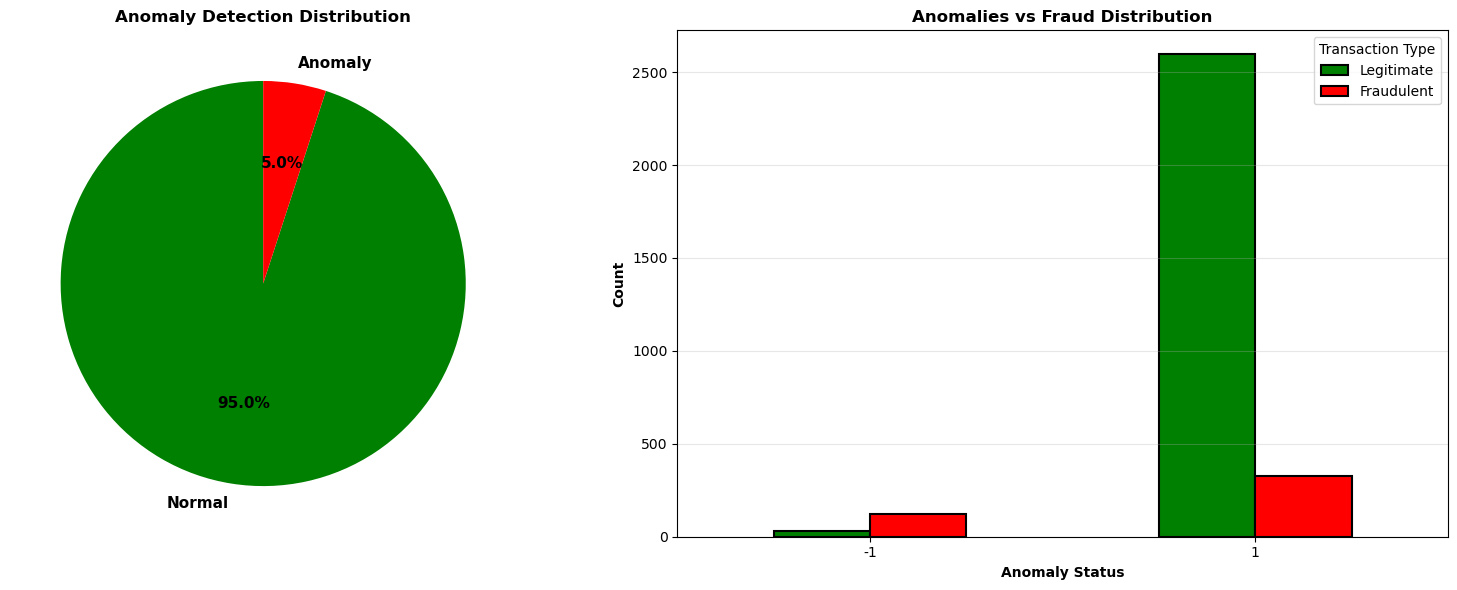


ANOMMLY DETECTION RESULTS:
Anomalies detected: 154 (5.01%)
Fraud rate in anomalies: 79.22%
Fraud rate in normal: 11.16%


In [43]:
# 3.6 ANOMALY DETECTION using Isolation Forest
from sklearn.ensemble import IsolationForest

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Detect anomalies
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(X)
X['anomaly'] = anomaly_labels

anomaly_counts = pd.Series(anomaly_labels).value_counts()
colors_anom = ['green', 'red']
labels_anom = ['Normal', 'Anomaly']

axes[0].pie(anomaly_counts.values, labels=labels_anom, autopct='%1.1f%%', 
           colors=colors_anom, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0].set_title('Anomaly Detection Distribution', fontweight='bold', fontsize=12)

# Cross-tabulation: Anomalies vs Fraud
crosstab = pd.crosstab(X['anomaly'], y)
crosstab.plot(kind='bar', ax=axes[1], color=['green', 'red'], edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Anomaly Status', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('Anomalies vs Fraud Distribution', fontweight='bold', fontsize=12)
axes[1].legend(['Legitimate', 'Fraudulent'], title='Transaction Type')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Statistics
fraud_in_anomalies = X[(X['anomaly'] == -1)]['anomaly'].count()
fraud_rate_anomaly = y[X['anomaly'] == -1].mean() * 100
print(f"\nANOMMLY DETECTION RESULTS:")
print(f"Anomalies detected: {(anomaly_labels == -1).sum()} ({(anomaly_labels == -1).sum()/len(X)*100:.2f}%)")
print(f"Fraud rate in anomalies: {fraud_rate_anomaly:.2f}%")
print(f"Fraud rate in normal: {y[X['anomaly'] == 1].mean()*100:.2f}%")

C:\Users\amine\AppData\Local\Temp\ipykernel_17396\1291220136.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='Fraud', y=feature, ax=ax, palette=['green', 'red'])
C:\Users\amine\AppData\Local\Temp\ipykernel_17396\1291220136.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='Fraud', y=feature, ax=ax, palette=['green', 'red'])
C:\Users\amine\AppData\Local\Temp\ipykernel_17396\1291220136.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='Fraud', y=feature, ax=ax, palette=[

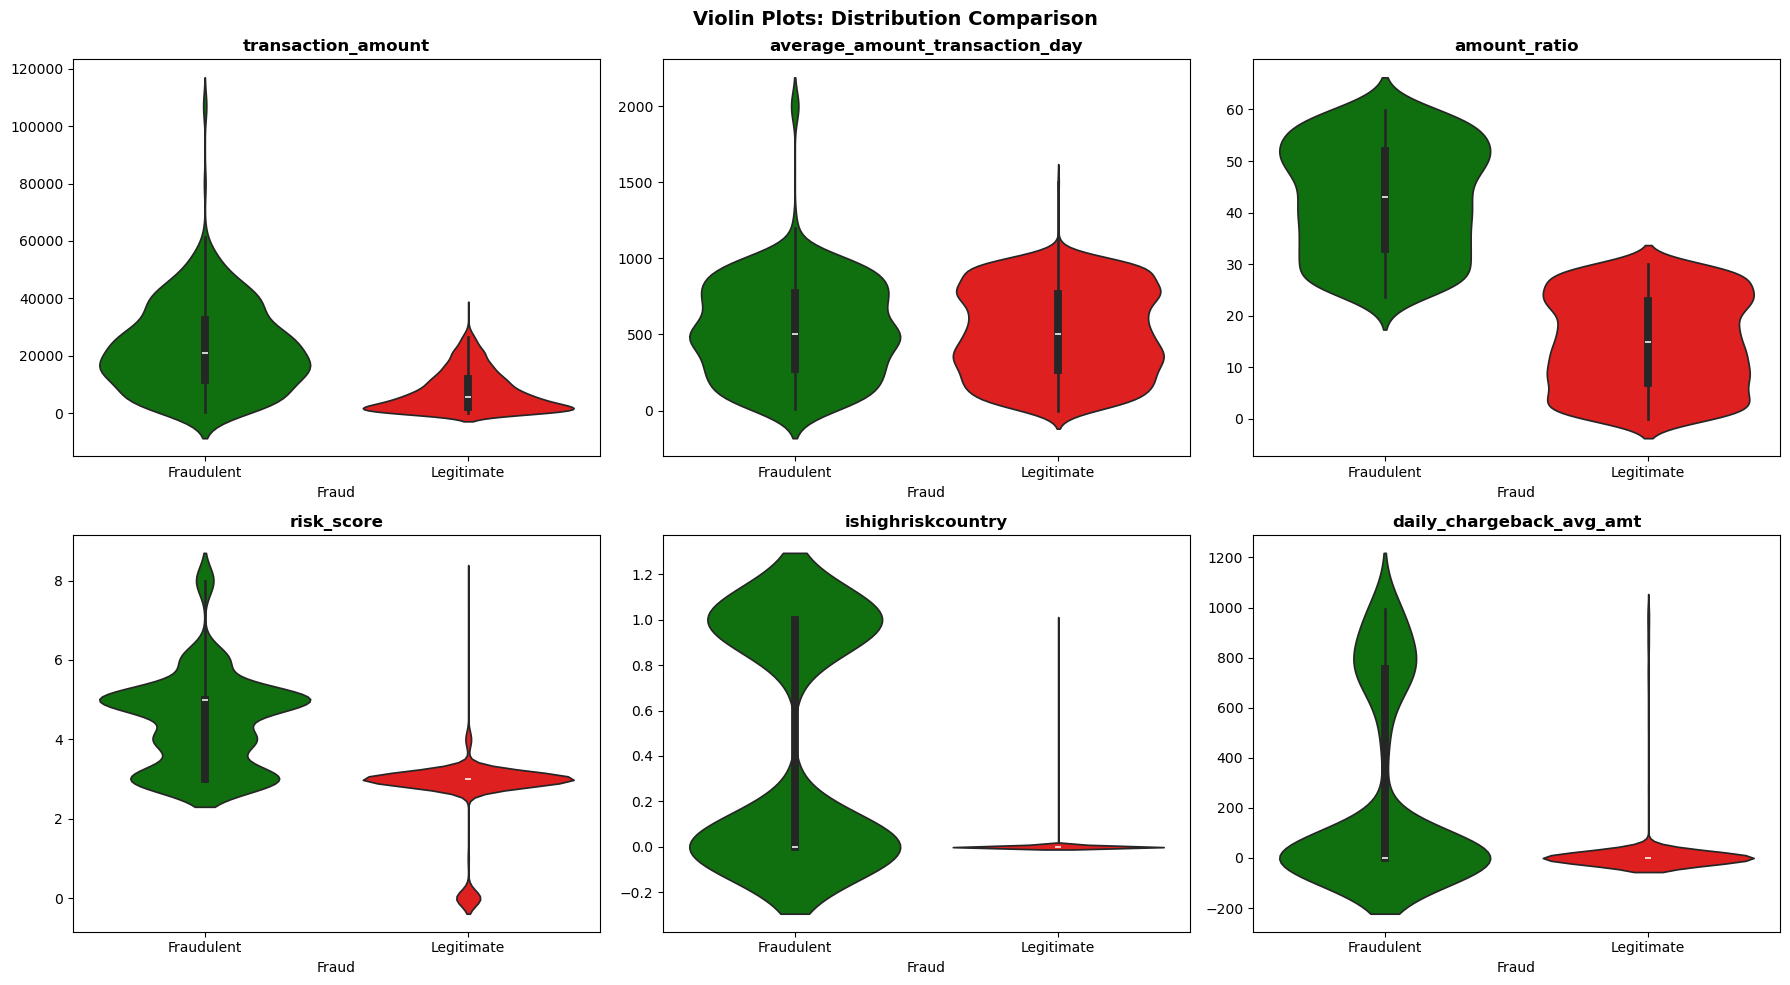

In [44]:
# 3.3 VIOLIN PLOTS - Distribution comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Violin Plots: Distribution Comparison', fontsize=14, fontweight='bold')

features = ['transaction_amount', 'average_amount_transaction_day', 'amount_ratio',
           'risk_score','ishighriskcountry', 'daily_chargeback_avg_amt']

plot_data = X.copy()
plot_data['Fraud'] = y.map({0: 'Legitimate', 1: 'Fraudulent'})

for idx, feature in enumerate(features):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    sns.violinplot(data=plot_data, x='Fraud', y=feature, ax=ax, palette=['green', 'red'])
    ax.set_title(f'{feature}', fontweight='bold')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

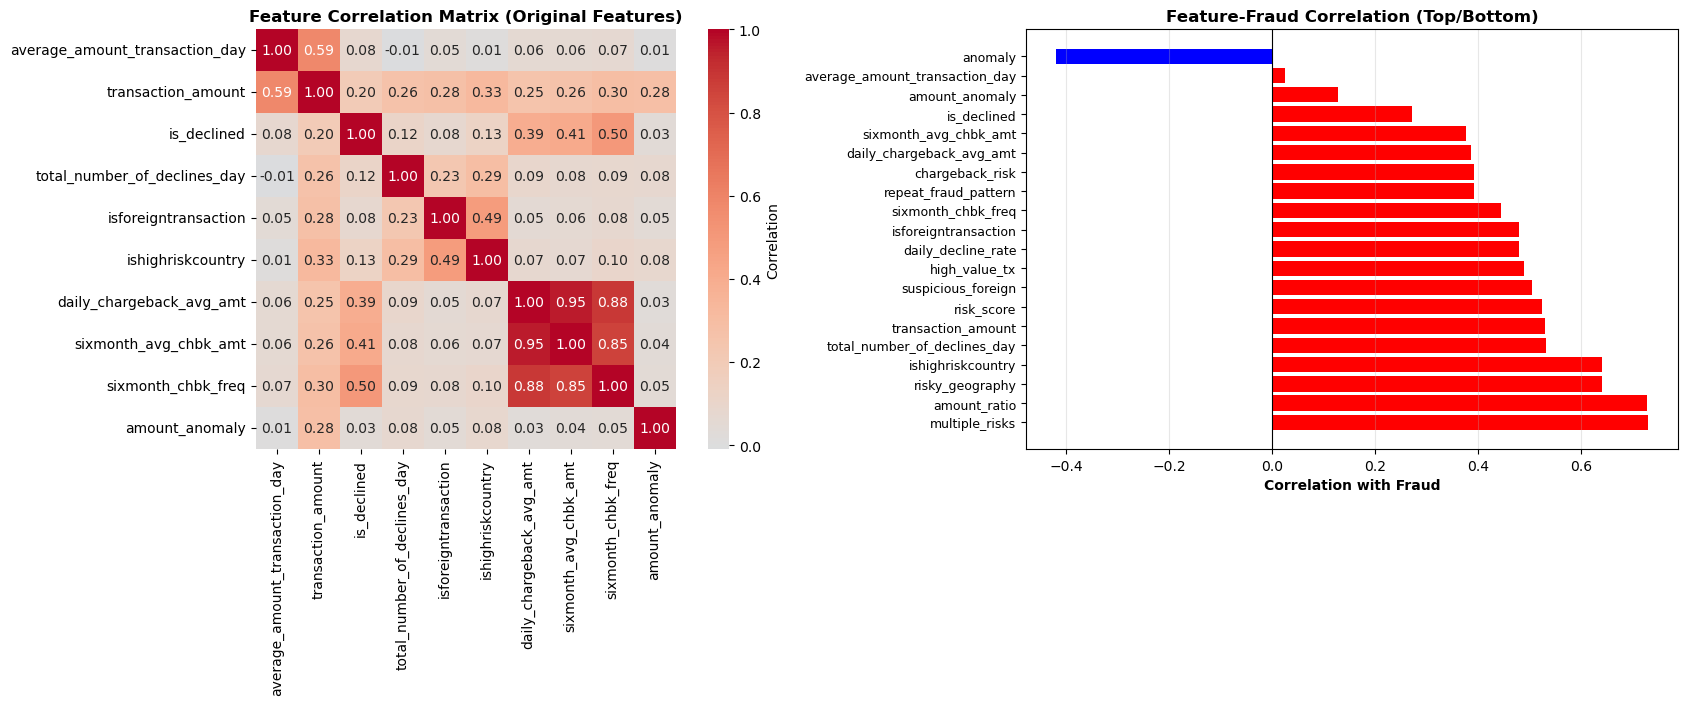


Top 10 Features Correlated with Fraud:
multiple_risks                  0.730563
amount_ratio                    0.727370
risky_geography                 0.639792
ishighriskcountry               0.639792
total_number_of_declines_day    0.531990
transaction_amount              0.528913
risk_score                      0.523005
suspicious_foreign              0.503601
high_value_tx                   0.488585
daily_decline_rate              0.478992
dtype: float64


In [45]:
# 3.1 CORRELATION HEATMAP
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Original features correlation
numeric_cols = X.select_dtypes(include=[np.number]).columns[:10]
corr_matrix = X[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            ax=axes[0], cbar_kws={'label': 'Correlation'}, square=True)
axes[0].set_title('Feature Correlation Matrix (Original Features)', fontsize=12, fontweight='bold')

# Fraud vs features correlation
feature_fraud_corr = X.corrwith(y).sort_values(ascending=False)
colors = ['red' if x > 0 else 'blue' for x in feature_fraud_corr.values]
axes[1].barh(range(len(feature_fraud_corr)), feature_fraud_corr.values, color=colors)
axes[1].set_yticks(range(len(feature_fraud_corr)))
axes[1].set_yticklabels(feature_fraud_corr.index, fontsize=9)
axes[1].set_xlabel('Correlation with Fraud', fontweight='bold')
axes[1].set_title('Feature-Fraud Correlation (Top/Bottom)', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
print("\nTop 10 Features Correlated with Fraud:")
print(feature_fraud_corr.head(10))

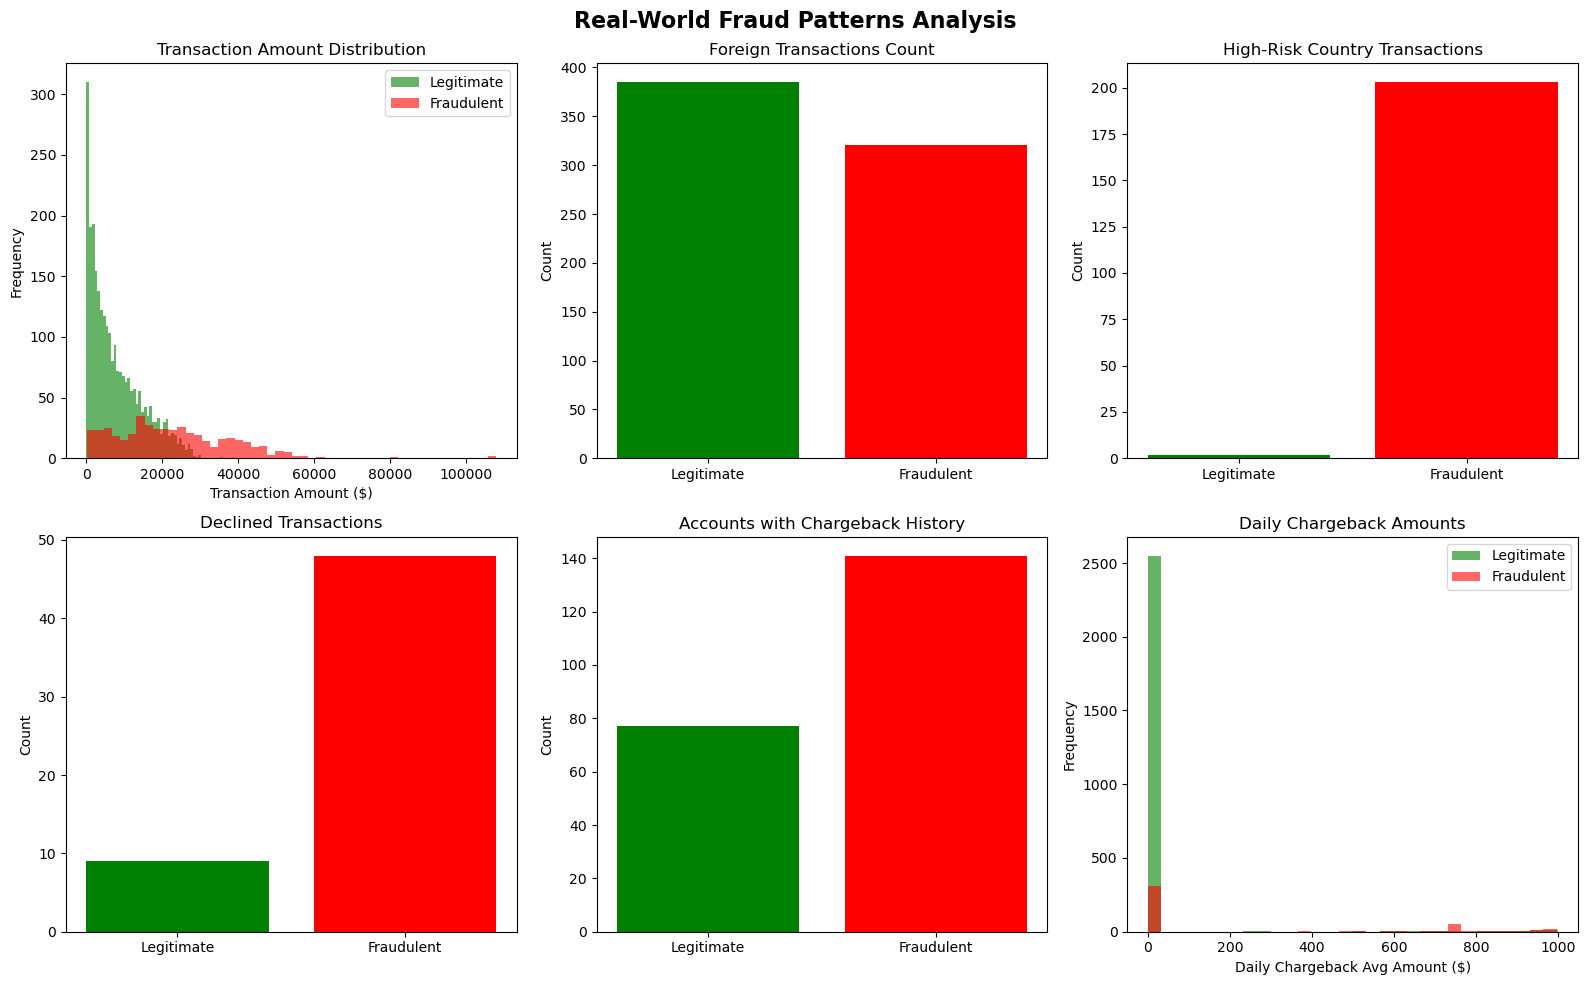

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Real-World Fraud Patterns Analysis', fontsize=16, fontweight='bold')

axes[0, 0].hist(legit_data['transaction_amount'], bins=50, alpha=0.6, label='Legitimate', color='green')
axes[0, 0].hist(fraud_data['transaction_amount'], bins=50, alpha=0.6, label='Fraudulent', color='red')
axes[0, 0].set_xlabel('Transaction Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Transaction Amount Distribution')
axes[0, 0].legend()

foreign_fraud = [legit_data['isforeigntransaction'].sum(), fraud_data['isforeigntransaction'].sum()]
axes[0, 1].bar(['Legitimate', 'Fraudulent'], foreign_fraud, color=['green', 'red'])
axes[0, 1].set_title('Foreign Transactions Count')
axes[0, 1].set_ylabel('Count')

risk_country = [legit_data['ishighriskcountry'].sum(), fraud_data['ishighriskcountry'].sum()]
axes[0, 2].bar(['Legitimate', 'Fraudulent'], risk_country, color=['green', 'red'])
axes[0, 2].set_title('High-Risk Country Transactions')
axes[0, 2].set_ylabel('Count')

declined = [legit_data['is_declined'].sum(), fraud_data['is_declined'].sum()]
axes[1, 0].bar(['Legitimate', 'Fraudulent'], declined, color=['green', 'red'])
axes[1, 0].set_title('Declined Transactions')
axes[1, 0].set_ylabel('Count')

chargeback = [(legit_data['sixmonth_chbk_freq'] > 0).sum(), (fraud_data['sixmonth_chbk_freq'] > 0).sum()]
axes[1, 1].bar(['Legitimate', 'Fraudulent'], chargeback, color=['green', 'red'])
axes[1, 1].set_title('Accounts with Chargeback History')
axes[1, 1].set_ylabel('Count')

axes[1, 2].hist(legit_data['daily_chargeback_avg_amt'], bins=30, alpha=0.6, label='Legitimate', color='green')
axes[1, 2].hist(fraud_data['daily_chargeback_avg_amt'], bins=30, alpha=0.6, label='Fraudulent', color='red')
axes[1, 2].set_xlabel('Daily Chargeback Avg Amount ($)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Daily Chargeback Amounts')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

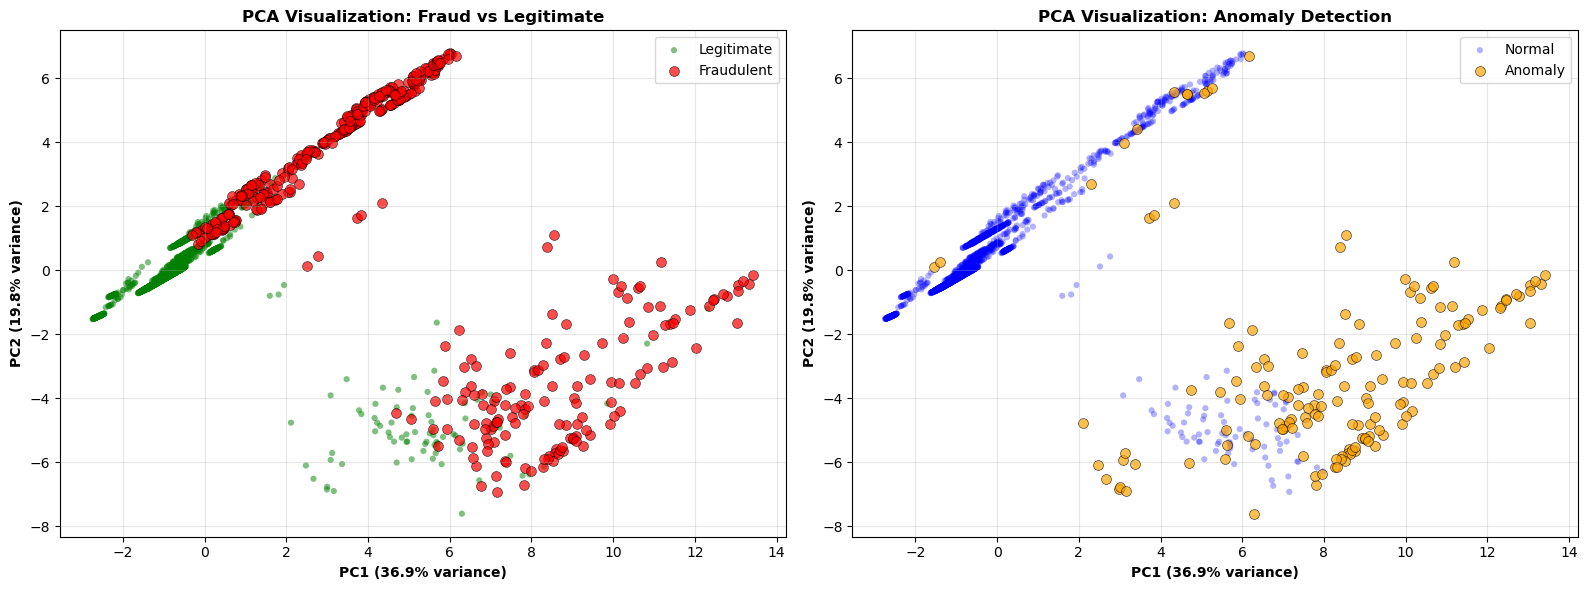


PCA ANALYSIS:
PC1 explains 36.90% of variance
PC2 explains 19.80% of variance
Total: 56.70%


In [47]:
# 3.7 PCA VISUALIZATION - Dimensionality reduction
scaler_viz = StandardScaler()
X_scaled = scaler_viz.fit_transform(X.drop('anomaly', axis=1))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA by fraud status
scatter1 = axes[0].scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], 
                           c='green', alpha=0.5, s=20, label='Legitimate', edgecolor='none')
scatter2 = axes[0].scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], 
                           c='red', alpha=0.7, s=50, label='Fraudulent', edgecolor='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
axes[0].set_title('PCA Visualization: Fraud vs Legitimate', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# PCA by anomaly
scatter3 = axes[1].scatter(X_pca[X['anomaly'] == 1, 0], X_pca[X['anomaly'] == 1, 1], 
                           c='blue', alpha=0.3, s=20, label='Normal', edgecolor='none')
scatter4 = axes[1].scatter(X_pca[X['anomaly'] == -1, 0], X_pca[X['anomaly'] == -1, 1], 
                           c='orange', alpha=0.7, s=50, label='Anomaly', edgecolor='black', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
axes[1].set_title('PCA Visualization: Anomaly Detection', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPCA ANALYSIS:")
print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

## 5. TRAIN-TEST SPLIT & MODEL PREPARATION

In [48]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]:,} transactions ({y_train.sum():,} fraud)")
print(f"Test set: {X_test.shape[0]:,} transactions ({y_test.sum():,} fraud)")
print(f"\nTraining set fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test set fraud rate: {y_test.mean()*100:.2f}%")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training set: 2,460 transactions (358 fraud)
Test set: 615 transactions (90 fraud)

Training set fraud rate: 14.55%
Test set fraud rate: 14.63%


## 6. TRAINING 7 MACHINE LEARNING MODELS

In [49]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(max_depth=15, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, 
                                           class_weight='balanced', n_jobs=-1),
    'SVM (Radial)': SVC(kernel='rbf', C=1.0, probability=True, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                                    max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, 
                            random_state=42, scale_pos_weight=10, tree_method='hist'),
    'LightGBM': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, 
                              random_state=42, is_unbalanced=True, verbose=-1)
}

trained_models = {}
model_predictions = {}
model_probabilities = {}

for name, model in models.items():
    
    if name in ['Logistic Regression', 'SVM (Radial)']:
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)
        probabilities = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        probabilities = model.predict_proba(X_test)[:, 1]
    
    trained_models[name] = model
    model_predictions[name] = predictions
    model_probabilities[name] = probabilities


## 7. COMPREHENSIVE MODEL EVALUATION & COMPARISON

In [50]:
results = []

for name in models.keys():
    preds = model_predictions[name]
    probs = model_probabilities[name]
    
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, zero_division=0)
    recall = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    roc_auc = roc_auc_score(y_test, probs)
    mcc = matthews_corrcoef(y_test, preds)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'MCC': mcc
    })

results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)
print("\n" + results_df.to_string(index=False))

print("MODEL RANKING")
for idx, row in results_df.iterrows():
    print(f"\n{idx+1}. {row['Model']}")
    print(f"   Precision: {row['Precision']:.3f} | Recall: {row['Recall']:.3f} | F1: {row['F1-Score']:.3f} | ROC-AUC: {row['ROC-AUC']:.3f}")


              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC      MCC
      Random Forest  0.993496   0.988636 0.966667  0.977528 0.997989 0.973810
  Gradient Boosting  0.993496   0.988636 0.966667  0.977528 0.999058 0.973810
            XGBoost  0.993496   0.988636 0.966667  0.977528 0.999386 0.973810
           LightGBM  0.993496   0.988636 0.966667  0.977528 0.998815 0.973810
Logistic Regression  0.990244   0.966667 0.966667  0.966667 0.998878 0.960952
      Decision Tree  0.988618   0.977011 0.944444  0.960452 0.970317 0.953994
       SVM (Radial)  0.986992   0.945652 0.966667  0.956044 0.996847 0.948490
MODEL RANKING

3. Random Forest
   Precision: 0.989 | Recall: 0.967 | F1: 0.978 | ROC-AUC: 0.998

5. Gradient Boosting
   Precision: 0.989 | Recall: 0.967 | F1: 0.978 | ROC-AUC: 0.999

6. XGBoost
   Precision: 0.989 | Recall: 0.967 | F1: 0.978 | ROC-AUC: 0.999

7. LightGBM
   Precision: 0.989 | Recall: 0.967 | F1: 0.978 | ROC-AUC: 0.999

1. Logistic Regression
   Precision

In [51]:
top_3_models = results_df.head(3)['Model'].tolist()

for model_name in top_3_models:
    print(f"{model_name}")
    preds = model_predictions[model_name]
    print(classification_report(y_test, preds, target_names=['Legitimate', 'Fraudulent'], digits=3))
    
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives: {tn:,} (correct rejections)")
    print(f"  False Positives: {fp:,} (legitimate flagged as fraud)")
    print(f"  False Negatives: {fn:,} (fraud missed)")
    print(f"  True Positives: {tp:,} (fraud correctly detected)")

Random Forest
              precision    recall  f1-score   support

  Legitimate      0.994     0.998     0.996       525
  Fraudulent      0.989     0.967     0.978        90

    accuracy                          0.993       615
   macro avg      0.991     0.982     0.987       615
weighted avg      0.993     0.993     0.993       615


Confusion Matrix:
  True Negatives: 524 (correct rejections)
  False Positives: 1 (legitimate flagged as fraud)
  False Negatives: 3 (fraud missed)
  True Positives: 87 (fraud correctly detected)
Gradient Boosting
              precision    recall  f1-score   support

  Legitimate      0.994     0.998     0.996       525
  Fraudulent      0.989     0.967     0.978        90

    accuracy                          0.993       615
   macro avg      0.991     0.982     0.987       615
weighted avg      0.993     0.993     0.993       615


Confusion Matrix:
  True Negatives: 524 (correct rejections)
  False Positives: 1 (legitimate flagged as fraud)
  Fa

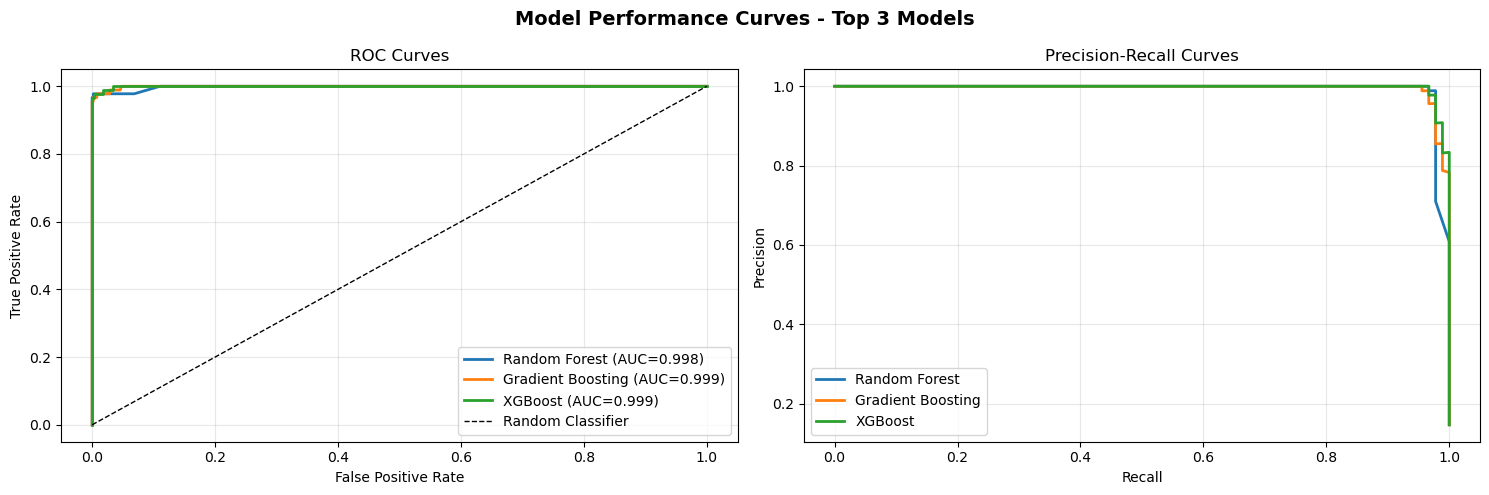

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Performance Curves - Top 3 Models', fontsize=14, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, model_name in enumerate(top_3_models):
    probs = model_probabilities[model_name]
    
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    axes[0].plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.3f})', linewidth=2, color=colors[idx])
    
    precision, recall, _ = precision_recall_curve(y_test, probs)
    axes[1].plot(recall, precision, label=model_name, linewidth=2, color=colors[idx])

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. BUSINESS IMPACT ANALYSIS - Real-World ROI

In [53]:
fraud_loss_per_incident = 500  
false_positive_cost = 50  
customer_churn_cost = 200 
daily_transaction_volume = 1_000_000 

print(f"\nCOST PARAMETERS:")
print(f"Fraud loss per incident: ${fraud_loss_per_incident}")
print(f"False positive cost: ${false_positive_cost} + ${customer_churn_cost} churn")
print(f"Daily transaction volume: {daily_transaction_volume:,}")

print("ROI ANALYSIS FOR TOP 3 MODELS")
for model_name in top_3_models:
    preds = model_predictions[model_name]
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    
    fraud_prevented = tp * fraud_loss_per_incident
    fraud_missed = fn * fraud_loss_per_incident
    false_positive_total_cost = fp * (false_positive_cost + customer_churn_cost)
    
    net_benefit = fraud_prevented - false_positive_total_cost
    
    roi_pct = (net_benefit / (fraud_prevented + fraud_missed)) * 100
    
    print(f"\n{model_name}:")
    print(f"Fraud Prevented: {tp} cases = ${fraud_prevented:,}")
    print(f"Fraud Missed: {fn} cases = ${fraud_missed:,} loss")
    print(f"False Positives: {fp} cases = ${false_positive_total_cost:,} cost")
    print(f"NET BENEFIT: ${net_benefit:,}")
    print(f"ROI: {roi_pct:.1f}%")

    test_size = len(y_test)
    annual_multiplier = (daily_transaction_volume / test_size) * 365
    annual_net_benefit = net_benefit * annual_multiplier
    print(f"ANNUAL PROJECTION: ${annual_net_benefit:,.0f}")


COST PARAMETERS:
Fraud loss per incident: $500
False positive cost: $50 + $200 churn
Daily transaction volume: 1,000,000
ROI ANALYSIS FOR TOP 3 MODELS

Random Forest:
Fraud Prevented: 87 cases = $43,500
Fraud Missed: 3 cases = $1,500 loss
False Positives: 1 cases = $250 cost
NET BENEFIT: $43,250
ROI: 96.1%
ANNUAL PROJECTION: $25,668,699,187

Gradient Boosting:
Fraud Prevented: 87 cases = $43,500
Fraud Missed: 3 cases = $1,500 loss
False Positives: 1 cases = $250 cost
NET BENEFIT: $43,250
ROI: 96.1%
ANNUAL PROJECTION: $25,668,699,187

XGBoost:
Fraud Prevented: 87 cases = $43,500
Fraud Missed: 3 cases = $1,500 loss
False Positives: 1 cases = $250 cost
NET BENEFIT: $43,250
ROI: 96.1%
ANNUAL PROJECTION: $25,668,699,187


## 9. REAL-WORLD DEPLOYMENT SCENARIOS

In [54]:
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\nUsing: {best_model_name}")
print("\nScenario: Bank processes a new transaction")
print("How the model makes decisions in production...\n")

sample_indices = np.where((y_test == 1))[0][:3]

for idx, sample_idx in enumerate(sample_indices, 1):
    if best_model_name in ['Logistic Regression', 'SVM (Radial)']:
        sample = X_test_scaled[sample_idx].reshape(1, -1)
    else:
        sample = X_test.iloc[[sample_idx]]
    
    pred_prob = best_model.predict_proba(sample)[0, 1]
    actual = y_test.iloc[sample_idx]
    
    print(f"\nTransaction #{idx}:")
    print(f"  Amount: ${X_test['transaction_amount'].iloc[sample_idx]:.2f}")
    print(f"  Foreign: {'Yes' if X_test['isforeigntransaction'].iloc[sample_idx] else 'No'}")
    print(f"  High-Risk Country: {'Yes' if X_test['ishighriskcountry'].iloc[sample_idx] else 'No'}")
    print(f"  Declined Previously: {'Yes' if X_test['is_declined'].iloc[sample_idx] else 'No'}")
    
    print(f"\nModel Decision:")
    print(f"  Fraud Probability: {pred_prob*100:.1f}%")
    
    if pred_prob >= 0.9:
        action = "BLOCK - High fraud risk"
    elif pred_prob >= 0.7:
        action = "REVIEW - Moderate fraud risk (verify with customer)"
    elif pred_prob >= 0.5:
        action = "MONITOR - Some fraud indicators present"
    else:
        action = "APPROVE - Low fraud risk"
    
    print(f"  {action}")
    print(f"  Actual: {'Fraudulent' if actual == 1 else 'Legitimate'}")


Using: Random Forest

Scenario: Bank processes a new transaction
How the model makes decisions in production...


Transaction #1:
  Amount: $42991.90
  Foreign: Yes
  High-Risk Country: No
  Declined Previously: No

Model Decision:
  Fraud Probability: 90.0%
  BLOCK - High fraud risk
  Actual: Fraudulent

Transaction #2:
  Amount: $22436.80
  Foreign: No
  High-Risk Country: No
  Declined Previously: No

Model Decision:
  Fraud Probability: 41.0%
  APPROVE - Low fraud risk
  Actual: Fraudulent

Transaction #3:
  Amount: $43000.00
  Foreign: Yes
  High-Risk Country: Yes
  Declined Previously: Yes

Model Decision:
  Fraud Probability: 98.0%
  BLOCK - High fraud risk
  Actual: Fraudulent


In [55]:
best_probs = model_probabilities[best_model_name]

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

print("\nImpact of Different Detection Thresholds:\n")

threshold_results = []
for threshold in thresholds:
    preds_threshold = (best_probs >= threshold).astype(int)
    
    if preds_threshold.sum() > 0:
        precision = precision_score(y_test, preds_threshold, zero_division=0)
        recall = recall_score(y_test, preds_threshold, zero_division=0)
        f1 = f1_score(y_test, preds_threshold, zero_division=0)
        
        cm = confusion_matrix(y_test, preds_threshold)
        if len(cm) == 2:
            tn, fp, fn, tp = cm.ravel()
        else:
            tp = cm[1, 1]
            fp = cm[0, 1] if len(cm) > 1 else 0
            fn = cm[1, 0] if len(cm) > 1 else 0
            tn = cm[0, 0]
    else:
        precision = recall = f1 = 0
        tp = fp = fn = 0
        tn = len(y_test) - y_test.sum()
    
    print(f"Threshold: {threshold:.1f}")
    print(f"  Precision: {precision:.3f} (of alerts, {precision*100:.1f}% are actual fraud)")
    print(f"  Recall: {recall:.3f} (catch {recall*100:.1f}% of fraud)")
    print(f"  F1-Score: {f1:.3f}")
    print(f"  TP: {tp} | FP: {fp} | FN: {fn}\n")
    
    threshold_results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Alerts': preds_threshold.sum()
    })

print("GUIDANCE:")
print("High threshold (0.9): Few alerts, very sure they're fraud, but miss real fraud")
print("Medium threshold (0.7): Balance between catching fraud and minimizing false alarms")
print("Low threshold (0.5): Catch most fraud but lots of false positives")
print("\n Most banks use 0.7-0.8 to balance fraud prevention with customer experience")


Impact of Different Detection Thresholds:

Threshold: 0.5
  Precision: 0.989 (of alerts, 98.9% are actual fraud)
  Recall: 0.967 (catch 96.7% of fraud)
  F1-Score: 0.978
  TP: 87 | FP: 1 | FN: 3

Threshold: 0.6
  Precision: 0.989 (of alerts, 98.9% are actual fraud)
  Recall: 0.967 (catch 96.7% of fraud)
  F1-Score: 0.978
  TP: 87 | FP: 1 | FN: 3



Threshold: 0.7
  Precision: 1.000 (of alerts, 100.0% are actual fraud)
  Recall: 0.967 (catch 96.7% of fraud)
  F1-Score: 0.983
  TP: 87 | FP: 0 | FN: 3

Threshold: 0.8
  Precision: 1.000 (of alerts, 100.0% are actual fraud)
  Recall: 0.944 (catch 94.4% of fraud)
  F1-Score: 0.971
  TP: 85 | FP: 0 | FN: 5

Threshold: 0.9
  Precision: 1.000 (of alerts, 100.0% are actual fraud)
  Recall: 0.900 (catch 90.0% of fraud)
  F1-Score: 0.947
  TP: 81 | FP: 0 | FN: 9

GUIDANCE:
High threshold (0.9): Few alerts, very sure they're fraud, but miss real fraud
Medium threshold (0.7): Balance between catching fraud and minimizing false alarms
Low threshold (0.5): Catch most fraud but lots of false positives

 Most banks use 0.7-0.8 to balance fraud prevention with customer experience


## 10. FEATURE IMPORTANCE - What Matters Most?

In [56]:
rf_model = trained_models['Random Forest']
xgb_model = trained_models['XGBoost']
gb_model = trained_models['Gradient Boosting']

feature_names = X_train.columns.tolist()

rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

gb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest - Top 10 Most Important Features")
print(rf_importance.head(10).to_string(index=False))

print("XGBoost - Top 10 Most Important Features")
print(xgb_importance.head(10).to_string(index=False))

print("Gradient Boosting - Top 10 Most Important Features")
print(gb_importance.head(10).to_string(index=False))

print("\nBUSINESS INTERPRETATION:")
top_3_features = rf_importance.head(3)['Feature'].tolist()
for idx, feature in enumerate(top_3_features, 1):
    print(f"  {idx}. {feature} - Top fraud indicator")

Random Forest - Top 10 Most Important Features
                     Feature  Importance
                amount_ratio    0.343432
                  risk_score    0.112914
              multiple_risks    0.087958
          suspicious_foreign    0.066180
          daily_decline_rate    0.061667
total_number_of_declines_day    0.061083
        isforeigntransaction    0.042319
          transaction_amount    0.040889
           ishighriskcountry    0.040263
             risky_geography    0.029060
XGBoost - Top 10 Most Important Features
                       Feature  Importance
                  amount_ratio    0.523783
                    risk_score    0.238738
          isforeigntransaction    0.050800
  total_number_of_declines_day    0.046231
             ishighriskcountry    0.038930
                   is_declined    0.019439
            sixmonth_chbk_freq    0.018408
         sixmonth_avg_chbk_amt    0.017382
            suspicious_foreign    0.014215
average_amount_transaction_day 

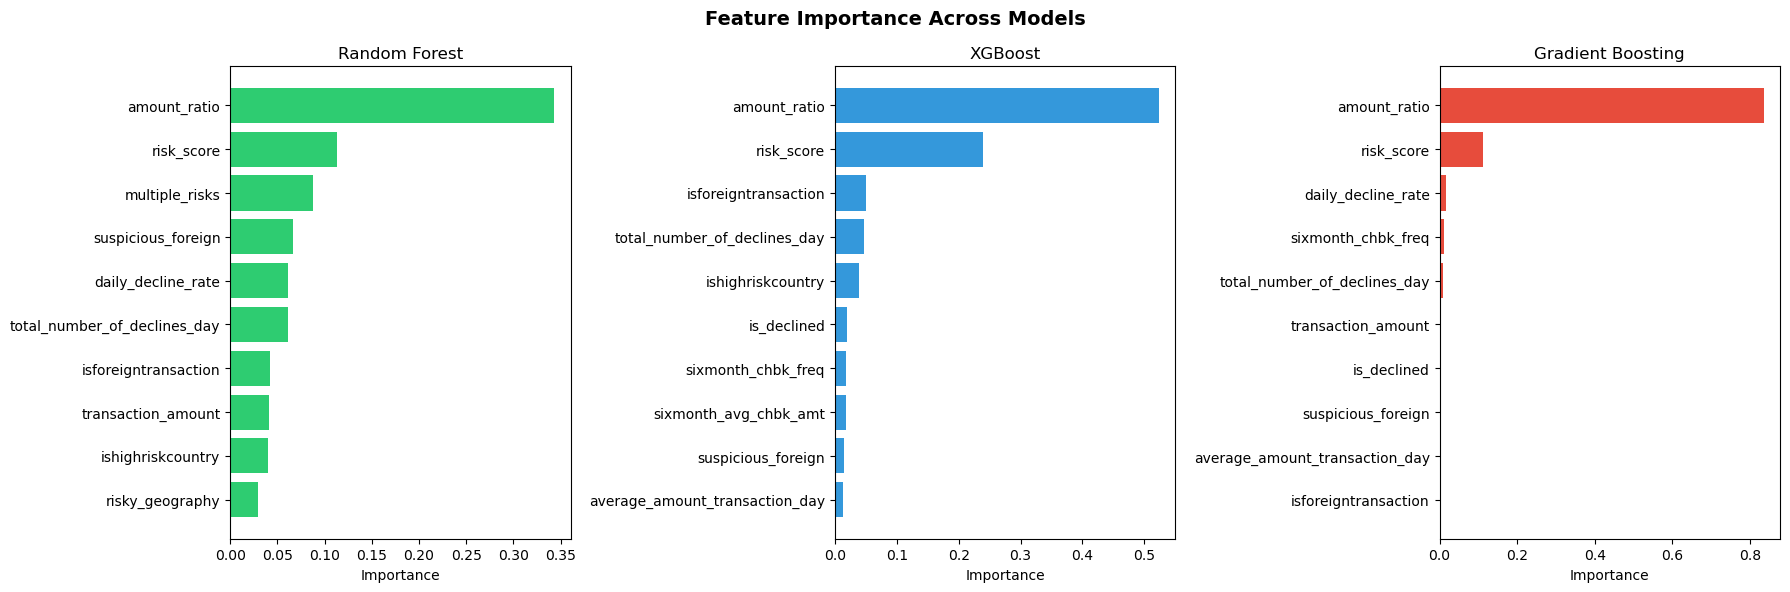

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Feature Importance Across Models', fontsize=14, fontweight='bold')

rf_top = rf_importance.head(10)
axes[0].barh(rf_top['Feature'], rf_top['Importance'], color='#2ecc71')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest')
axes[0].invert_yaxis()

xgb_top = xgb_importance.head(10)
axes[1].barh(xgb_top['Feature'], xgb_top['Importance'], color='#3498db')
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost')
axes[1].invert_yaxis()

gb_top = gb_importance.head(10)
axes[2].barh(gb_top['Feature'], gb_top['Importance'], color='#e74c3c')
axes[2].set_xlabel('Importance')
axes[2].set_title('Gradient Boosting')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()